In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#from keras.utils import np_utils
from keras import utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

Dataset

In [2]:
!pip install -q kaggle

In [3]:
#import kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"triwahyuprabowo","key":"4a1b6691d8c16ea90c3a46ddd044a72e"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [01:04<00:00, 22.8MB/s]
100% 1.33G/1.33G [01:04<00:00, 22.1MB/s]


In [6]:
!unzip -qq celeba-dataset.zip

Explore Data

In [2]:
# set variables
main_folder = '/content'
images_folder = '/content/img_align_celeba/img_align_celeba/'

EXAMPLE_PIC = '/content/img_align_celeba/img_align_celeba/000572.jpg'

TRAINING_SAMPLES = 4000
VALIDATION_SAMPLES = 100
TEST_SAMPLES = 10
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20


In [3]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv('/content/list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape
df_attr

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202595.jpg,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
202596.jpg,0,0,0,0,0,1,1,0,0,1,...,0,1,1,0,0,0,0,0,0,1
202597.jpg,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [4]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


Smiling    1
Male       1
Young      1
Name: 000572.jpg, dtype: int64

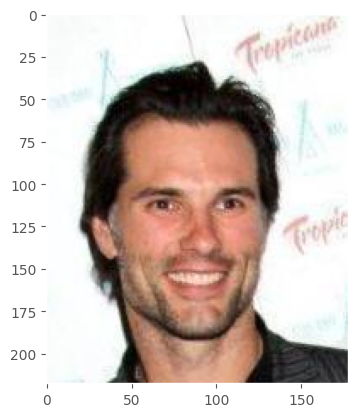

In [5]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

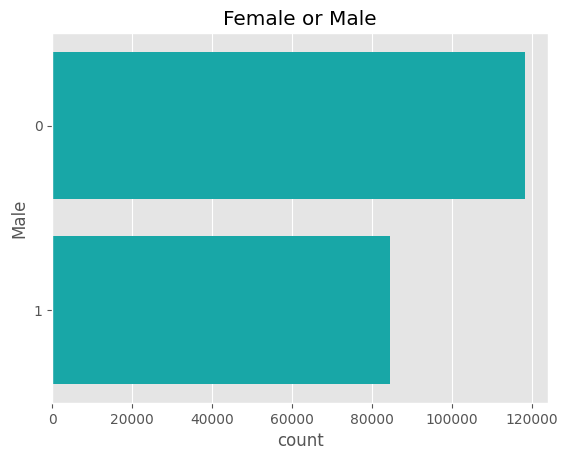

In [6]:
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

In [7]:
# Recomended partition
df_partition = pd.read_csv('/content/list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [8]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

In [9]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


In [23]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test

    '''

    df_ = df_par_attr[(df_par_attr['partition'] == partition)
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition)
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = keras.utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

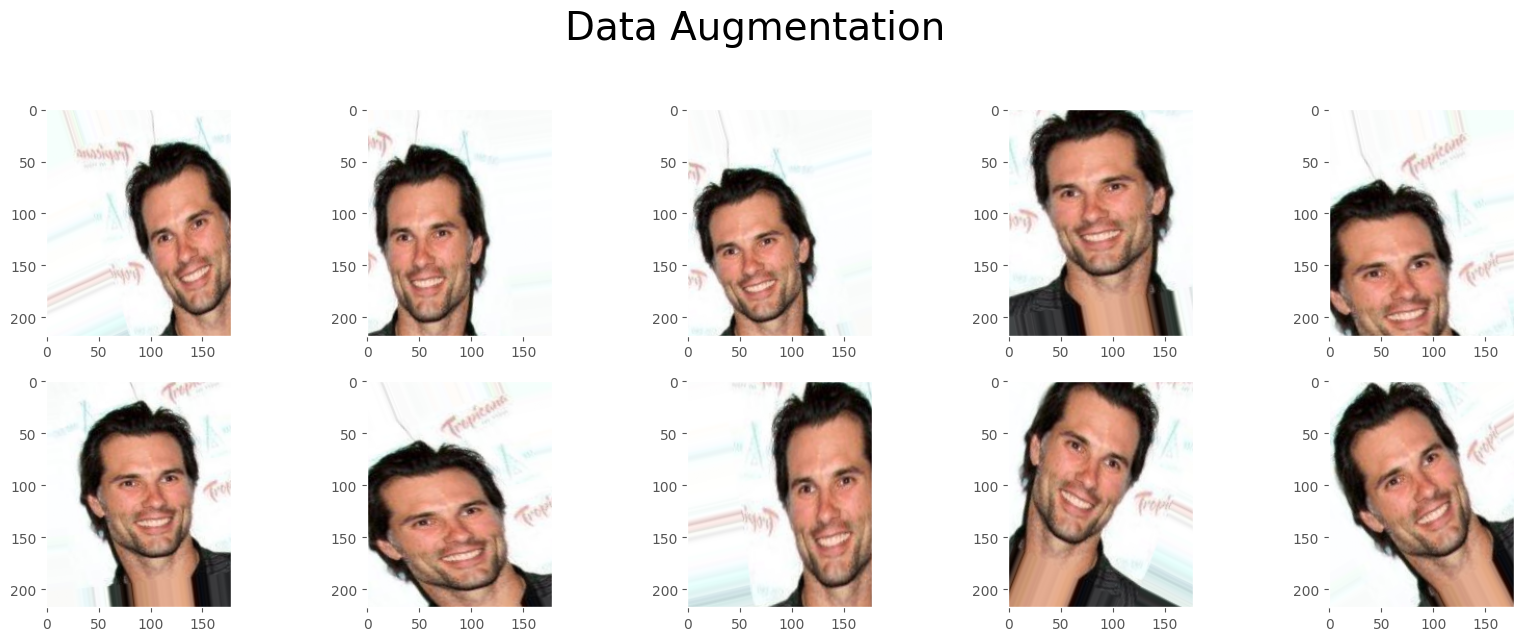

In [11]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape

img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))

    if i == 9:
        break
    i += 1

plt.show()


In [24]:

# Train data
x_train, y_train = generate_df(0, 'Male', TRAINING_SAMPLES)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

In [25]:
# Validation Data
x_valid, y_valid = generate_df(1, 'Male', VALIDATION_SAMPLES)

'''
# Validation - Data Preparation - Data Augmentation with generators
valid_datagen = ImageDataGenerator(
  preprocessing_function=preprocess_input,
)

valid_datagen.fit(x_valid)

validation_generator = valid_datagen.flow(
x_valid, y_valid,
)
'''

'\n# Validation - Data Preparation - Data Augmentation with generators\nvalid_datagen = ImageDataGenerator(\n  preprocessing_function=preprocess_input,\n)\n\nvalid_datagen.fit(x_valid)\n\nvalidation_generator = valid_datagen.flow(\nx_valid, y_valid,\n)\n'

In [27]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
inc_model.summary()

87910968/87910968 [==============================] - 5s 0us/step
number of layers: 311
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 218, 178, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 108, 88, 32)          864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 108, 88, 32)          96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  


In [28]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(2, activation="softmax")(x)

In [30]:
# creating the final model
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [ ]:
'''
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.male.hdf5',
                               verbose=1, save_best_only=True)

In [35]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , verbose=1
                    )

Epoch 1/20


<ipython-input-35-050d2be79c3b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_.fit_generator(train_generator


250/250 [==============================] - 56s 226ms/step - loss: 0.6962 - accuracy: 0.5630 - val_loss: 0.7053 - val_accuracy: 0.5500
Epoch 2/20
250/250 [==============================] - 49s 195ms/step - loss: 0.6263 - accuracy: 0.6545 - val_loss: 0.7437 - val_accuracy: 0.5200
Epoch 3/20
250/250 [==============================] - 46s 186ms/step - loss: 0.5478 - accuracy: 0.7185 - val_loss: 0.9284 - val_accuracy: 0.4800
Epoch 4/20
250/250 [==============================] - 47s 188ms/step - loss: 0.5106 - accuracy: 0.7427 - val_loss: 0.9379 - val_accuracy: 0.4900
Epoch 5/20
250/250 [==============================] - 47s 186ms/step - loss: 0.4636 - accuracy: 0.7770 - val_loss: 0.9076 - val_accuracy: 0.5300
Epoch 6/20
250/250 [==============================] - 46s 183ms/step - loss: 0.4335 - accuracy: 0.7922 - val_loss: 0.9584 - val_accuracy: 0.5100
Epoch 7/20
250/250 [==============================] - 47s 186ms/step - loss: 0.4097 - accuracy: 0.8142 - val_loss: 0.9090 - val_accuracy: 0.4

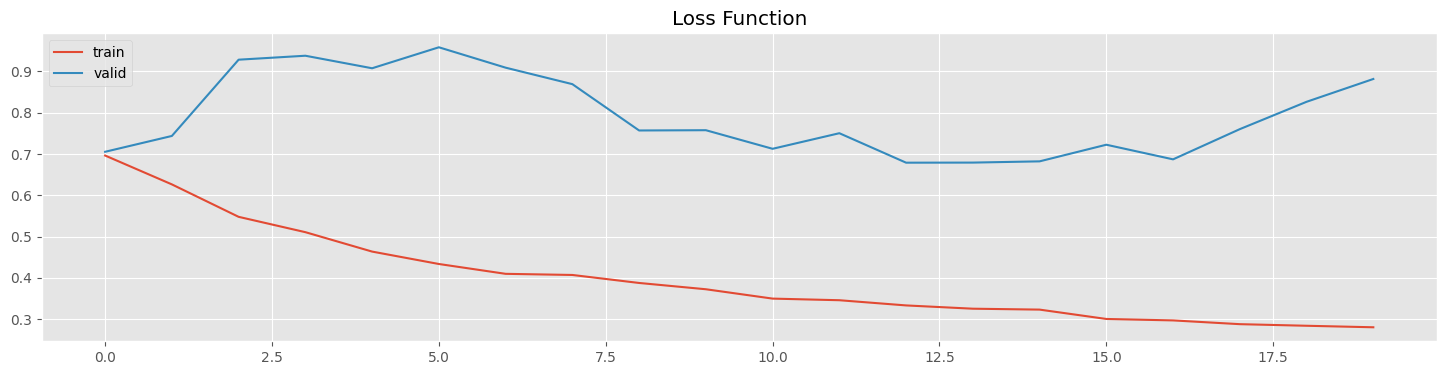

In [36]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()


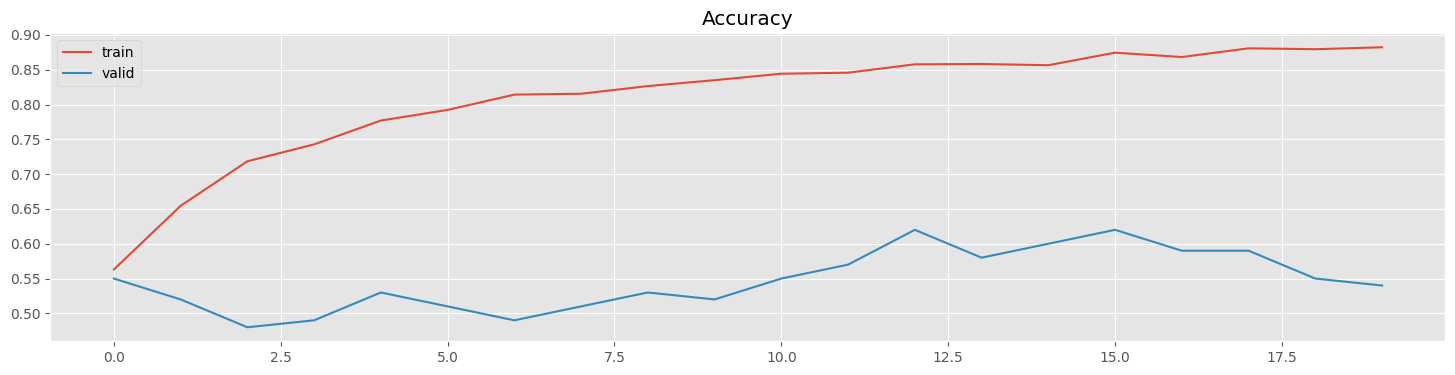

In [39]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['accuracy'], label = 'train')
plt.plot(hist.history['val_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

Save Model

In [46]:
model_.save("gender_model.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


eval


In [47]:
#load the best model
model_.load_weights('/content/gender_model.hdf5')

In [48]:
# Test Data
x_test, y_test = generate_df(2, 'Male', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions))

1/1 [==============================] - 0s 28ms/step
Model Evaluation
Test accuracy: 50.0000%
f1_score: 0.5454545454545454


display model


In [49]:
#dictionary to name the prediction
gender_target = {0: 'Female'
                , 1: 'Male'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    # credits to stassl :)

    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)

    with BytesIO() as buffer:
        i.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()


def display_result(filename, prediction, target):
    '''
    Display the results in HTML

    '''

    gender = 'Male'
    gender_icon = "https://i.imgur.com/nxWan2u.png"

    if prediction[1] <= 0.5:
        gender_icon = "https://i.imgur.com/oAAb8rd.png"
        gender = 'Female'

    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: -6px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: -16px; font-size: 12px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , gender_icon
               , gender
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , gender_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [50]:
def gender_prediction(filename):
    '''
    predict the gender

    input:
        filename: str of the file name

    return:
        array of the prob of the targets.

    '''

    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (178, 218)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)

    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)

    return result

1/1 [==============================] - 0s 27ms/step



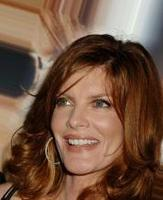

1/1 [==============================] - 0s 26ms/step



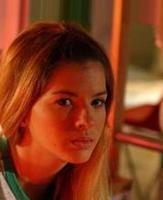

1/1 [==============================] - 0s 26ms/step



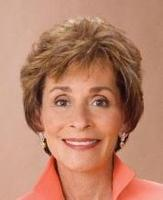

1/1 [==============================] - 0s 28ms/step



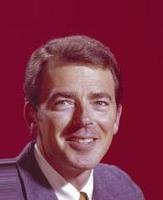

1/1 [==============================] - 0s 25ms/step



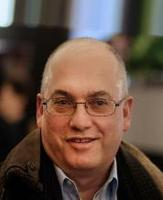

1/1 [==============================] - 0s 28ms/step



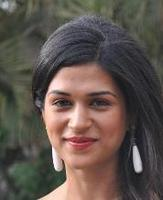

1/1 [==============================] - 0s 32ms/step



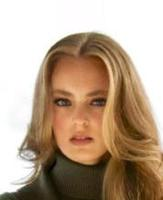

1/1 [==============================] - 0s 24ms/step



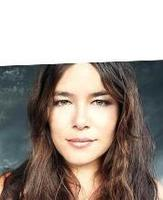

In [51]:
#select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(8)

for index, target in df_to_test.iterrows():
    result = gender_prediction(images_folder + index)

    #display result
    display_result(images_folder + index, result[0], target['Male'])